# Generalized Additive Models

For this to work you need to install pyGAM `pip install pygam` (https://pygam.readthedocs.io) 

In [13]:
import glm_utils
import matplotlib.pyplot as plt
import numpy as np
import sklearn.linear_model
import sklearn.model_selection
from sklearn.metrics import r2_score
from pygam import GAM, LinearGAM, s, f, te

from demo_utils import get_data
plt.style.use('ncb.mplstyle')

# Generate toy data 
The stimulus `x` (`[time, stimuli]`) corresponds to four stimuli - for instance the distance, angle, velocity, and acceleration of flies.

The response `y` (`[time,]`) is produced by filtering each of the four stimuli in `x` with a filter (given by `filters`) and summing.

The filters are defined with the righmost value (delay 0) being closest to the response and the leftmost being furthest into the past (delay -50)

x: (100000, 4), y: (100000,), filters (50, 4)


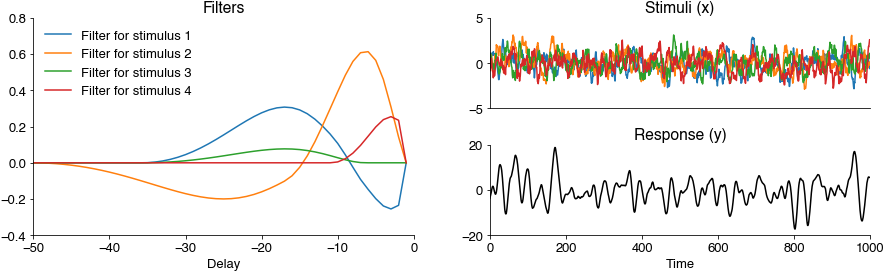

In [14]:
x, y, filters = get_data(npoints = 100_000)

nb_points, nb_stim = x.shape
filter_duration = filters.shape[0]
T = np.arange(-filter_duration, 0)

print(f"x: {x.shape}, y: {y.shape}, filters {filters.shape}")
plt.figure(figsize=[15,4])
plt.subplot(121)
plt.plot(T, filters)
plt.title('Filters')
plt.xlabel('Delay')
plt.legend([f'Filter for stimulus {f}' for f in range(1,5)])

plt.subplot(222)
plt.plot(x[:1000])
plt.title('Stimuli (x)')
plt.xticks(())

plt.subplot(224)
plt.plot(y[:1000], c='k')
plt.title('Response (y)')
plt.xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()


In [15]:
nb_delays = 50
X, y_m = glm_utils.preprocessing.time_delay_embedding(x, y, window_size=nb_delays)
print(X.shape)


(99950, 200)


In [16]:
# construct the basis functions
B = glm_utils.bases.raised_cosine(0, 12, [0, 36], 16, nb_delays)
B_multi = glm_utils.bases.multifeature_basis(B, nb_features=nb_stim)
# intialize basis_projection object
basis_projection = glm_utils.preprocessing.BasisProjection(B_multi)
_, nb_bases = B.shape
T = np.arange(-nb_delays, 0)

print(f"Before basis projection: X {X.shape},  y {y_m.shape}.")
X_b = basis_projection.transform(X)
print(f"After basis projection: X {X_b.shape},  y {y_m.shape}.")

Before basis projection: X (99950, 200),  y (99950,).
After basis projection: X (99950, 48),  y (99950,).


In [17]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_b, y_m, test_size=0.2)
print(f"Shape of training set: {X_train.shape}, test set: {X_test.shape}")

Shape of training set: (79960, 48), test set: (19990, 48)


In [19]:
ga = GAM(s(0, n_splines=200) , distribution='normal', link='identity')
ga.fit(X_train, y_train)

GAM(callbacks=[Deviance(), Diffs()], distribution=NormalDist(), 
   fit_intercept=True, link=IdentityLink(), max_iter=100, 
   terms=s(0) + intercept, tol=0.0001, verbose=False)

In [20]:
gam = LinearGAM()
gam.gridsearch(X_train[:1000, :], y_train[:1000])


100% (11 of 11) |########################| Elapsed Time: 0:00:22 Time:  0:00:22


LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, 
   terms=s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + s(11) + s(12) + s(13) + s(14) + s(15) + s(16) + s(17) + s(18) + s(19) + s(20) + s(21) + s(22) + s(23) + s(24) + s(25) + s(26) + s(27) + s(28) + s(29) + s(30) + s(31) + s(32) + s(33) + s(34) + s(35) + s(36) + s(37) + s(38) + s(39) + s(40) + s(41) + s(42) + s(43) + s(44) + s(45) + s(46) + s(47) + intercept,
   tol=0.0001, verbose=False)

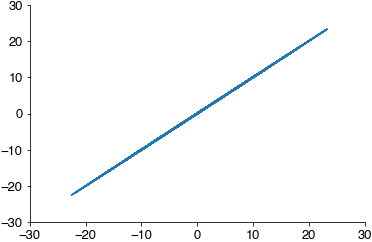

In [21]:
# filters = basis_projection.inverse_transform(gam.coef_
plt.plot(gam.predict(X_test), y_test)

In [24]:
len(gam.terms)

49

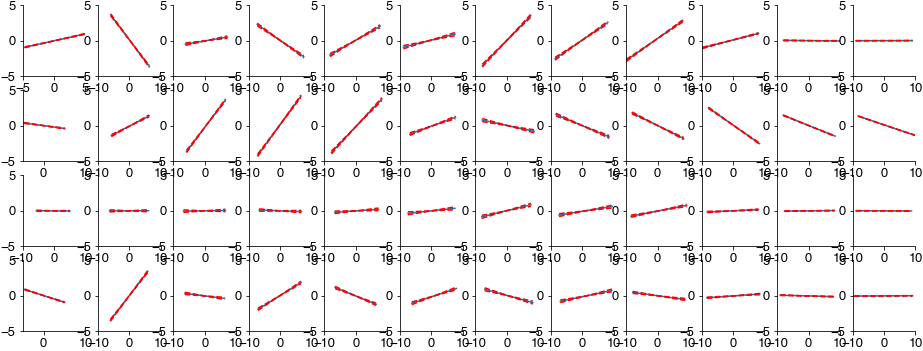

In [27]:
fig, axs = plt.subplots(nb_stim, nb_bases, figsize=(16, 6));
axs = axs.ravel()
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    ax.set_ylim(-5, 5)